# Detect pertinent images in PDF

This notebook provides examples on how to detect images that are pertinent. 

These images will be summarized using a multimodal model

We will use CLIP to detect graphs and tables in PDFs.

The data used for this example is a french PDF from our company, providing exmplainations on RAG and Agents. 

Let's try the zero shot learning approach

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import List
from transformers import CLIPProcessor, CLIPModel
from unstructured.partition.pdf import partition_pdf
sys.path.append("../")

In [2]:
PDF_PATH = "../data/pdf/long.pdf"
DETECTED_IMAGE_DIRECTORY = "../data/pdf/extracted_images/long/long_pdf"

### Load text and images from PDF

In [3]:
elements = partition_pdf(
    filename=PDF_PATH,
    infer_table_structure=True,
    strategy="hi_res",
    include_page_breaks=True,
    chunking_strategy='auto',
    extract_images_in_pdf=True,
    extract_image_block_output_dir=DETECTED_IMAGE_DIRECTORY
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def open_images_from_directory(directory_path: str):
    images = os.listdir(directory_path)
    return [Image.open(os.path.join(directory_path, img)) for img in images]

### Predict images label: graph, table, other

In [5]:
def get_pertinent_images(images: List[Image.Image], labels: List[str]):
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    inputs = processor(text=labels, images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    return probs

In [6]:
LABELS = ["graph", "table", "other"]
images = open_images_from_directory(DETECTED_IMAGE_DIRECTORY)
print("Number of images:", len(images))
probs = get_pertinent_images(images, LABELS)

Number of images: 211


### Keep only pertinent images, graphs and tables predicted by CLIP with high confidence (90%)

In [7]:
# Conservons les images qavec une probabilité sur les labels graphes et tableaux supérieures à 0.9
graphs_found = [[img, label_prob[0].item()] for (img, label_prob) in zip(images, probs) if label_prob[0].item() > 0.9]
tables_found = [[img, label_prob[1].item()] for (img, label_prob) in zip(images, probs) if label_prob[1].item() > 0.9]
other_found = [[img, label_prob[2].item()] for (img, label_prob) in zip(images, probs) if label_prob[0].item() <= 0.9 or label_prob[1].item() <= 0.9]

print(f'Graphs found: {len(graphs_found)}')
print(f'Tables found: {len(tables_found)}')
print(f'Other images found: {len(other_found)}')


Graphs found: 11
Tables found: 0
Other images found: 211


### Display results

In [8]:
def display_multiple_images(images: List[Image.Image], probs: List[float]):
    # Max number of images to display
    images = images[:60]
    probs = probs[:60]

    columns = 4
    rows = (len(images) // columns) + 1
    fig = plt.figure(figsize=(9, 13))


    # ax enables access to manipulate each of subplots
    ax = []

    for i, img in enumerate(images):
        img = images[i]
        prob = np.round(probs[i], 3)
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].axis("off")
        ax[-1].set_title("Proba:"+str(prob), fontsize=7)  # set title
        plt.imshow(img, alpha=0.9)

    plt.show()  # finally, render the plot

In [9]:
# Graph founds
display_multiple_images([img[0] for img in graphs_found], [img[1] for img in graphs_found])

NameError: name 'plt' is not defined

In [ ]:
# Table found
display_multiple_images([img[0] for img in tables_found], [img[1] for img in tables_found])

<Figure size 900x1300 with 0 Axes>

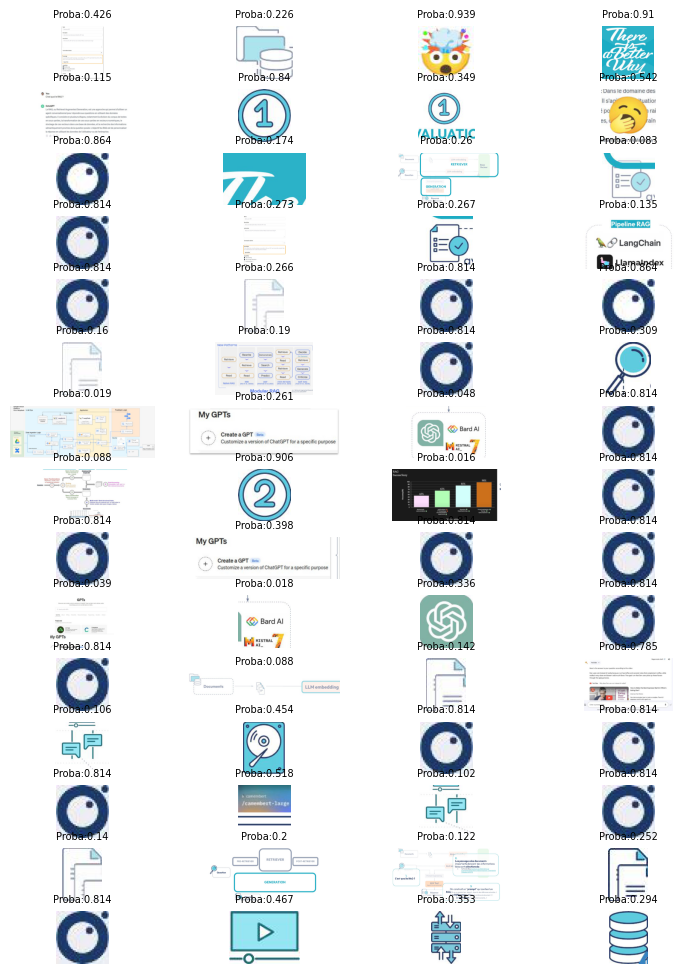

In [ ]:
display_multiple_images([img[0] for img in other_found], [img[1] for img in other_found])

## Conclusion 

95 % of images were considered as not being graph nor table and will be discarded.

The CLIP model is used as zero shot learning. We will see in the next notebook how to fine tune the model to detect pertinent images.

